In [1]:
import os
import collections

import numpy  as np
import pandas as pd

import matplotlib.pyplot as plt

import invisible_cities.core.fit_functions as fitf

In [2]:
profile = collections.namedtuple("profile", "x y u")

In [3]:
%matplotlib inline

plt.rcParams["figure.figsize"] = 12, 8
plt.rcParams[  "font.size"   ] = 15

In [4]:
path_tables       = "/Users/Gonzalo/github/NEXTdata/NEWtables/"
filename_cathode  = os.path.join(path_tables,      "Cathode.dat")
filename_anode    = os.path.join(path_tables,        "Anode.dat")
filename_pmt_map  = os.path.join(path_tables,  "pmt_mapping.dat")
filename_sipm_map = os.path.join(path_tables, "sipm_mapping.dat")
filename_el_map   = os.path.join(path_tables,   "el_mapping.dat")
filename_maps     = os.path.join(path_tables,      "NEW_maps.py")

In [5]:
def load_cathode_df(filename, EL_map):
    df_cathode = pd.DataFrame.from_csv(filename, sep=" ", index_col=None)
    df_cathode["Sum"] = df_cathode.values[:, 3:].sum(axis=1)
    df_cathode["X"  ] = df_cathode.PointID.transform(lambda ID: EL_map[ID][0])
    df_cathode["Y"  ] = df_cathode.PointID.transform(lambda ID: EL_map[ID][1])
    df_cathode["R"  ] = np.sqrt   (df_cathode.X**2 + df_cathode.Y**2)
    df_cathode["Phi"] = np.arctan2(df_cathode.Y, df_cathode.X)

    new_columns = ["Dummy", "PointID", "SensorID", "X", "Y", "R", "Phi", "Sum"] + [f"P{i}" for i in range(20)]
    df_cathode = df_cathode.reindex(columns = new_columns)
    df_cathode.sort_values("SensorID")
    return df_cathode


def fix_cathode_file(filename):
    file_data = open(filename_cathode, "r").read()
    modified  = False

    if str.isdigit(file_data[0]):
        header    = "Dummy PointID SensorID P0 P1 P2 P3 P4 P5 P6 P7 P8 P9 P10 P11 P12 P13 P14 P15 P16 P17 P18 P19\n"
        file_data = header + file_data 
        modified  = True

    if " \n" in file_data:
        file_data = file_data.replace(" \n", "\n")
        modified  = True

    if modified:
        open(filename, "w").write(file_data)

In [6]:
pmt  = pd.DataFrame.from_csv(filename_pmt_map , sep=" ", index_col=None)
sipm = pd.DataFrame.from_csv(filename_sipm_map, sep=" ", index_col=None)
el   = pd.DataFrame.from_csv(filename_el_map  , sep=" ", index_col=None)

# Defines maps
exec(open(filename_maps).read())

fix_cathode_file(filename_cathode)
df_cathode = load_cathode_df(filename_cathode, EL_map)

In [7]:
assert np.nan not in df_cathode
df_cathode.head()

,Dummy,PointID,SensorID,X,Y,R,Phi,Sum,P0,P1,...,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19
0,1,1060,0,-186.0,-29.0,188.247178,-2.986924,0.000437,0.000020,0.000022,...,0.000022,0.000020,0.000022,0.000022,0.000022,0.000025,0.000022,0.000022,0.000023,0.000020
1,1,1060,1,-186.0,-29.0,188.247178,-2.986924,0.000437,0.000019,0.000022,...,0.000023,0.000022,0.000022,0.000022,0.000023,0.000022,0.000021,0.000022,0.000023,0.000022
2,1,1060,2,-186.0,-29.0,188.247178,-2.986924,0.000429,0.000021,0.000024,...,0.000022,0.000022,0.000020,0.000023,0.000021,0.000021,0.000023,0.000021,0.000019,0.000023
3,1,1060,3,-186.0,-29.0,188.247178,-2.986924,0.000318,0.000014,0.000017,...,0.000016,0.000014,0.000017,0.000014,0.000016,0.000015,0.000016,0.000016,0.000016,0.000014
4,1,1060,4,-186.0,-29.0,188.247178,-2.986924,0.000329,0.000014,0.000014,...,0.000019,0.000017,0.000017,0.000016,0.000018,0.000017,0.000016,0.000016,0.000014,0.000016


# Control plots

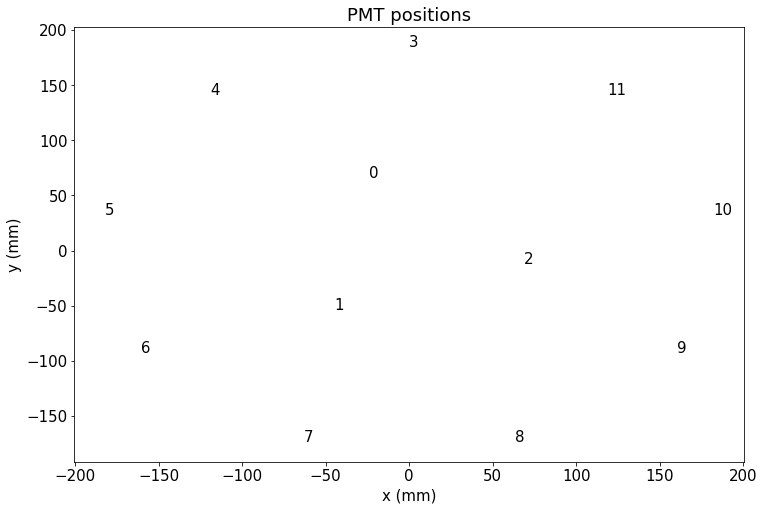

In [60]:
plt.scatter(pmt.X, pmt.Y, s=0)
for row_no, row in pmt.iterrows():
    plt.text(row.X, row.Y, str(int(row.SensorID)))
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.title ("PMT positions");

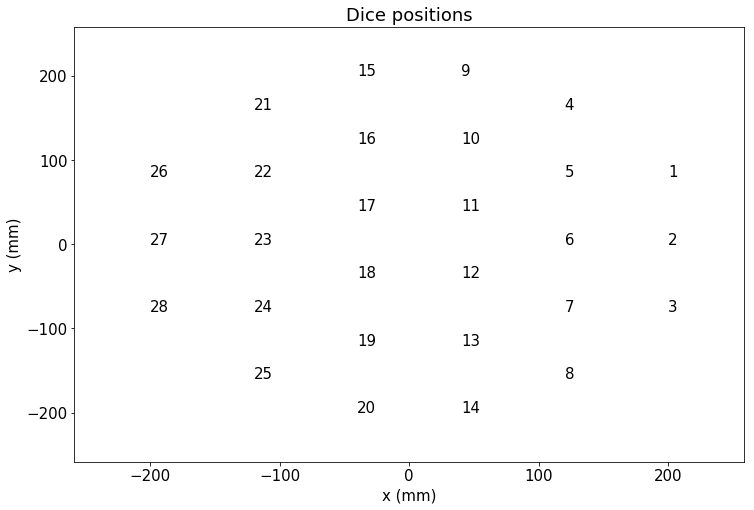

In [61]:
plt.scatter(sipm.X, sipm.Y, s=0)
for dice_no, dice in sipm.groupby("Dice"):
    x = dice.X.mean()
    y = dice.Y.mean()
    plt.text(x, y, str(int(dice_no)))
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.title ("Dice positions");

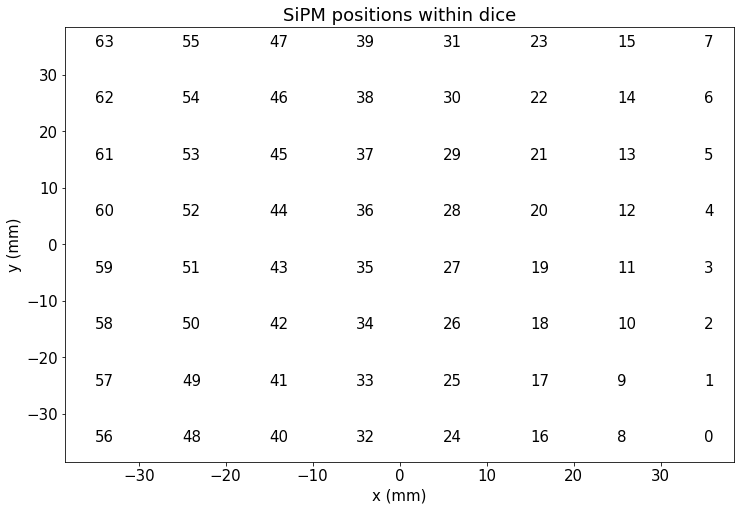

In [62]:
for dice_no, dice in sipm.groupby("Dice"):
    xmean = dice.X.mean()
    ymean = dice.Y.mean()
    plt.scatter(dice.X - xmean, dice.Y - ymean, s=0)
    for row_no, row in dice.iterrows():
        plt.text(row.X - xmean, row.Y - ymean, str(int(row.SensorID - 1000 * dice_no)))
    break
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.title ("SiPM positions within dice");

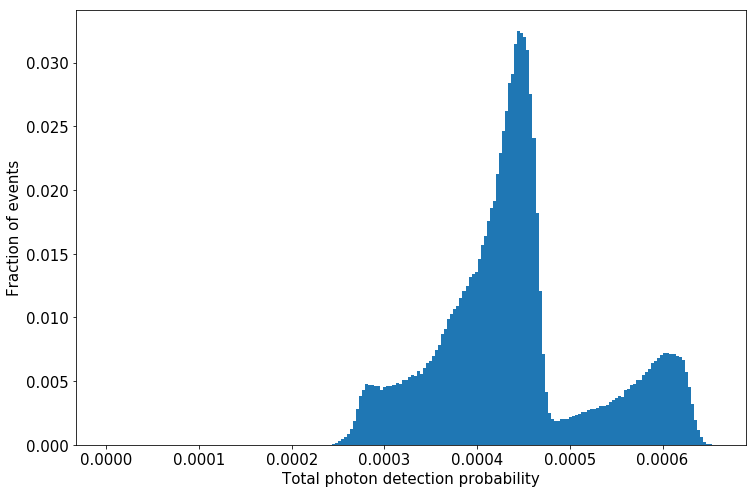

In [63]:
bins    = np.linspace(0, np.max(df_cathode.Sum), 201)
weights = np.ones(len(df_cathode)) / len(df_cathode)
plt.hist(df_cathode.Sum, bins = bins, weights = weights)
plt.xlabel("Total photon detection probability")
plt.ylabel("Fraction of events")

# PMT parametrization

In [64]:
def find_pitch(data):
    return np.min(np.diff(np.sort(np.unique(data))))

def find_nbins(data, d):
    return int(np.ceil((data.max() - data.min()) / d)) + 2

def find_binning(data):
    d = find_pitch(data)
    n = find_nbins(data, d)
    return np.linspace(df_cathode.X.min() - d/2,
                       df_cathode.X.max() + d/2,
                       n)

In [65]:
x_binning = find_binning(df_cathode.X)
y_binning = find_binning(df_cathode.Y)
r_binning = np.linspace(0, np.max(df_cathode.R  ) * 1.001, 201)
p_binning = np.linspace(0, np.max(df_cathode.Sum) * 1.001, 201)

/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6497: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None


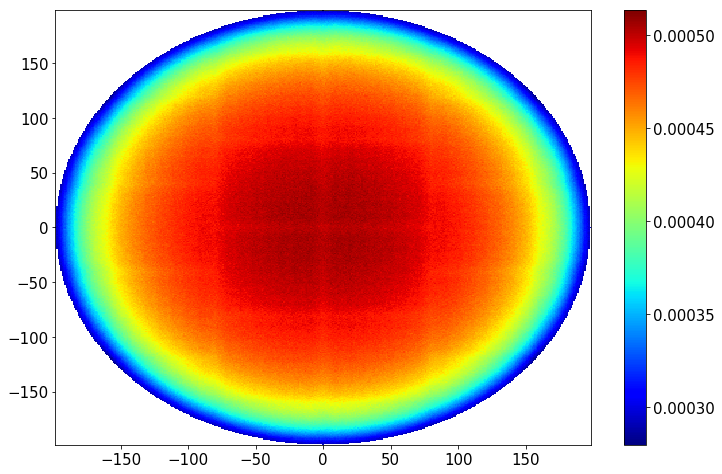

In [66]:
plt.hist2d(df_cathode.X, df_cathode.Y,
           (x_binning, y_binning),
           weights = df_cathode.Sum / 12,
#           vmin    = df_cathode.Sum.min(),
#           vmax    = df_cathode.Sum.max(),
           cmin    = df_cathode.Sum.min(),
           cmax    = df_cathode.Sum.max(),
           cmap    = "jet"
          )

plt.colorbar()

In [84]:
parametrizations = {}
profiles         = {}
pulls            = {}
for pmt_no, pmt in df_cathode.groupby("SensorID"):
    x, y, u = fitf.profileX(pmt.R, pmt.Sum, r_binning.size - 1, (r_binning[0], r_binning[-1]))
    ok = u > 0
    f  = fitf.fit(fitf.polynom, x[ok], y[ok], (-1, +1, -1, +1, -1, +1, pmt.Sum.max()), sigma=u[ok], maxfev=int(1e5))

    prediction = f.fn(pmt.R)
    pull       = (prediction - pmt.Sum) / (prediction * 1e-7)**0.5

    parametrizations[pmt_no] = f
    profiles        [pmt_no] = profile(x, y, u)
    pulls           [pmt_no] = pull

/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


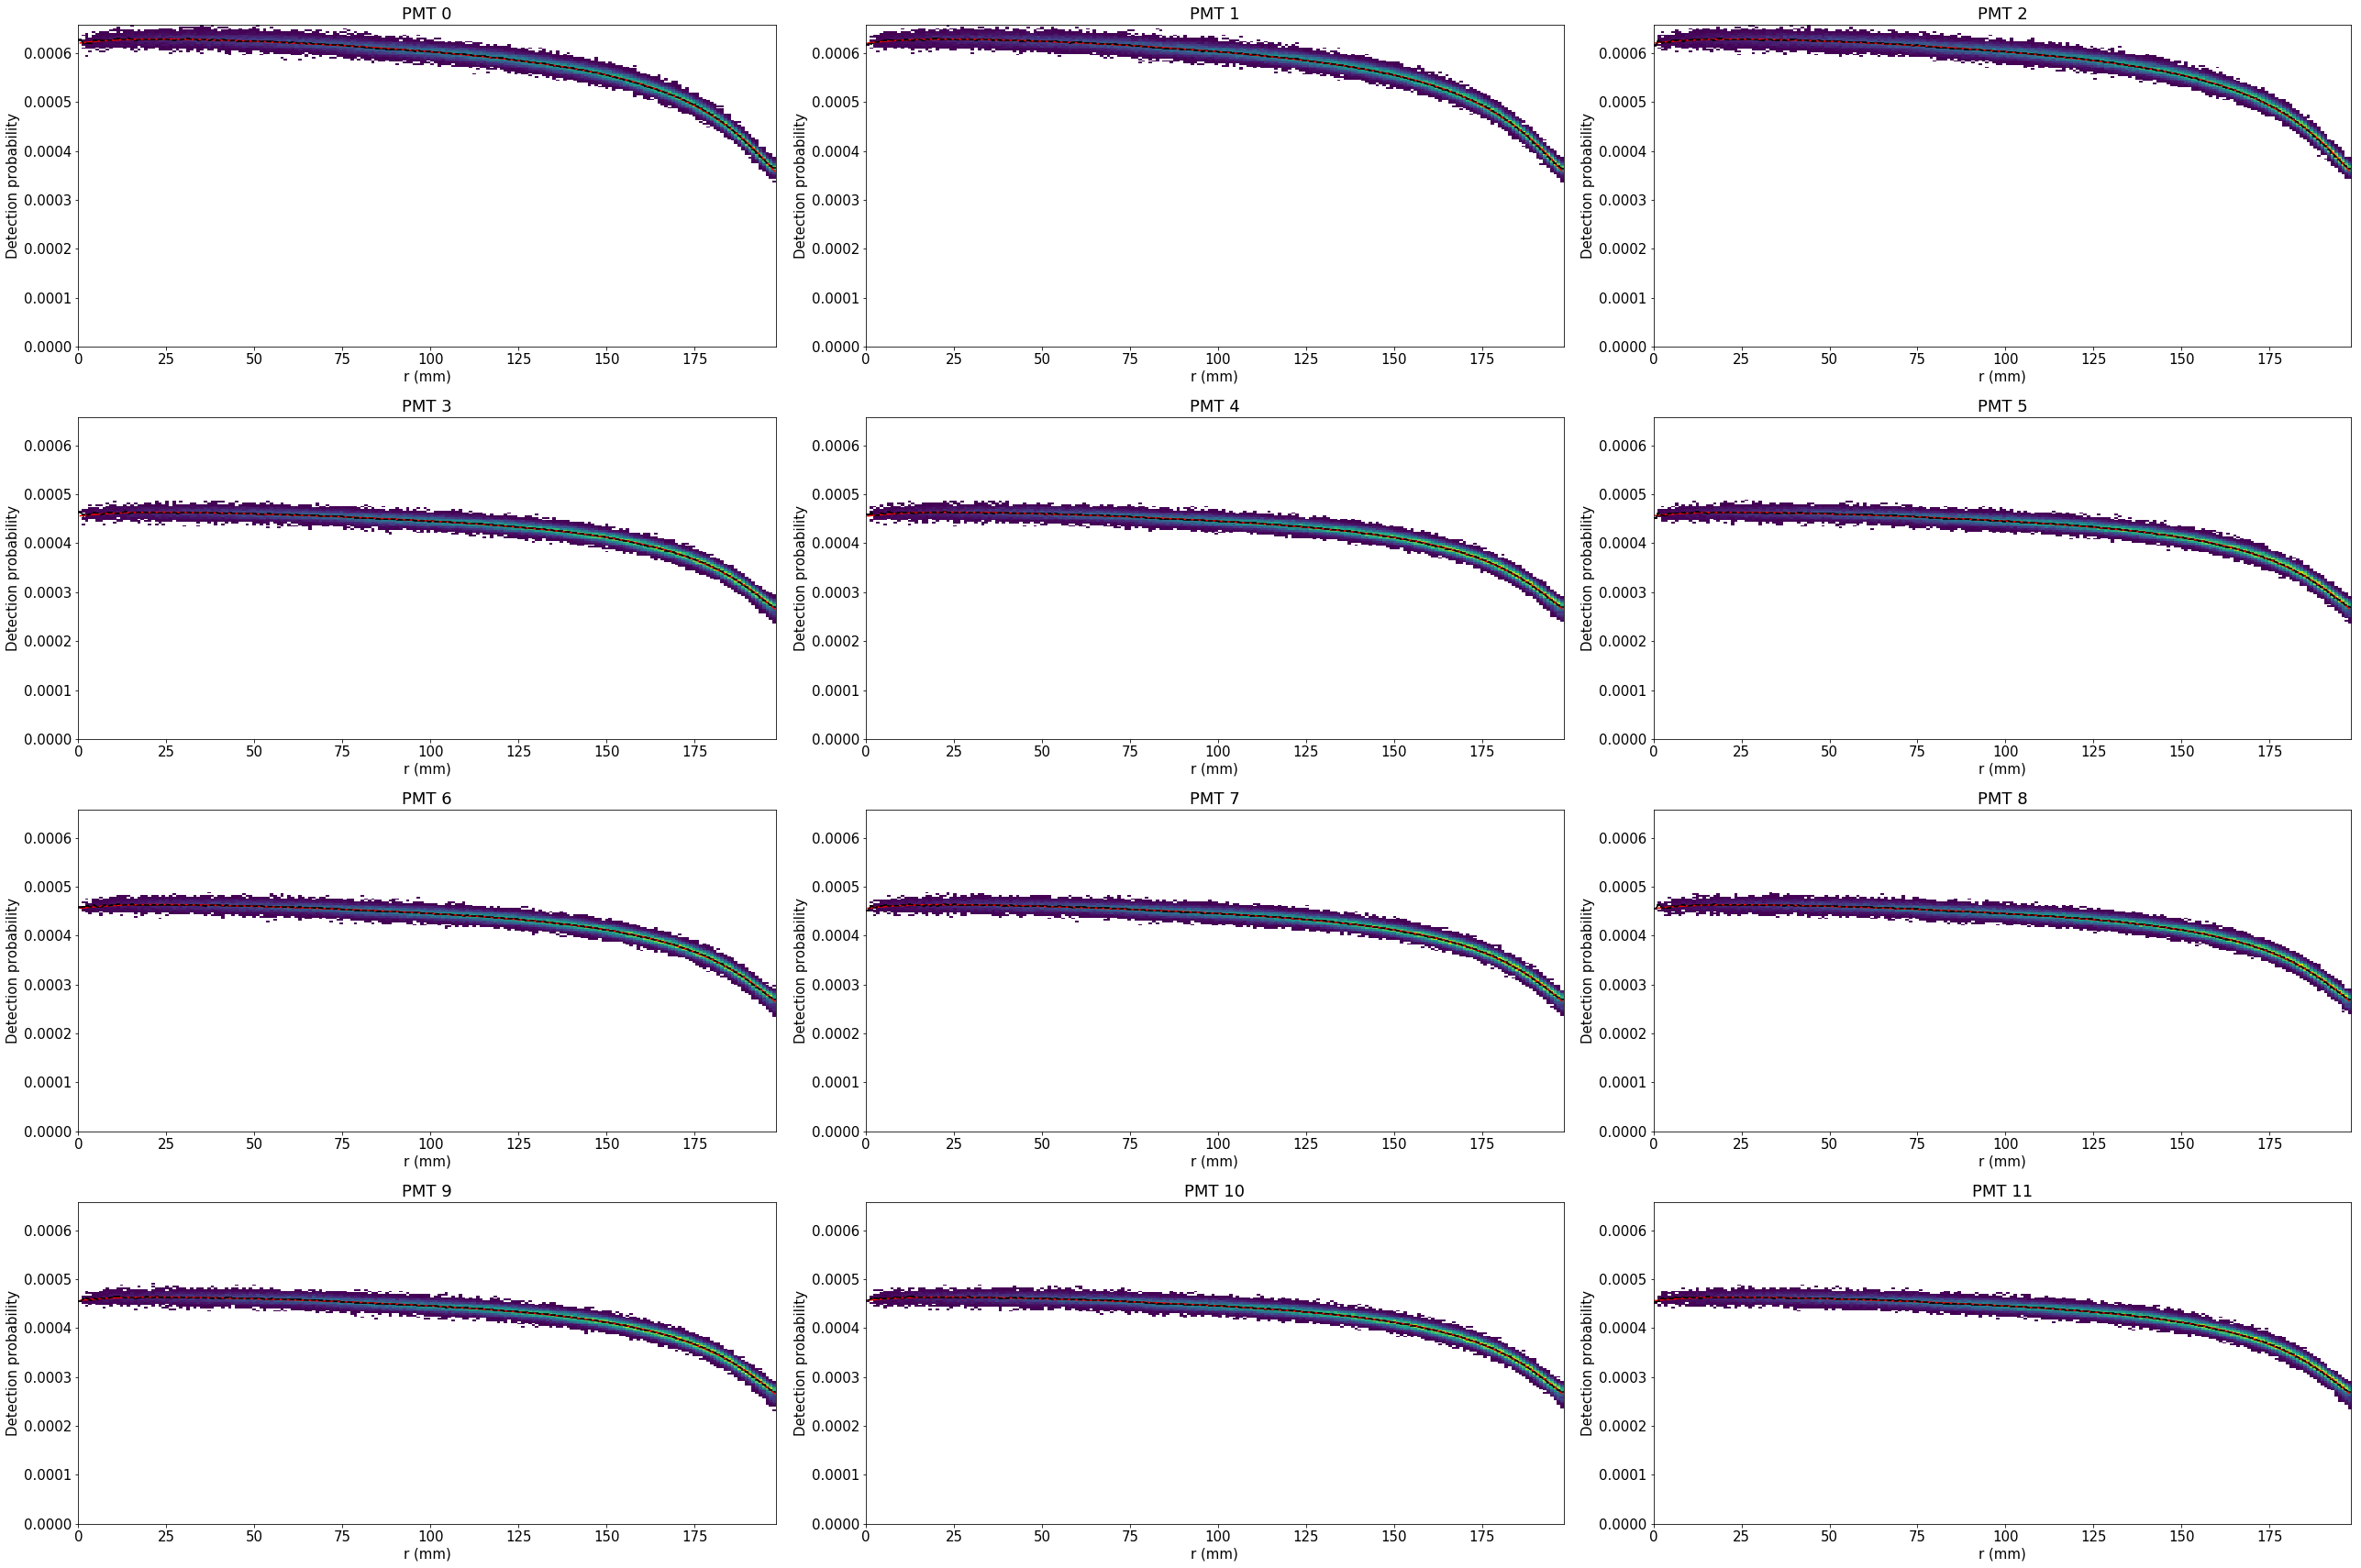

In [85]:
plt.figure(figsize=(36, 24))

for pmt_no, pmt in df_cathode.groupby("SensorID"):
    (x, y, u), f = profiles[pmt_no], parametrizations[pmt_no]

    plt.subplot(4, 3, pmt_no + 1)
    plt.hist2d(pmt.R, pmt.Sum, (r_binning, p_binning), cmin = 1e-8)
    plt.errorbar(x, y, u, np.diff(r_binning) / 2, "--k")
    plt.plot    (x, f.fn(x), "-r")
    plt.xlabel("r (mm)")
    plt.ylabel("Detection probability")
    plt.title (f"PMT {pmt_no}")
    plt.tight_layout()

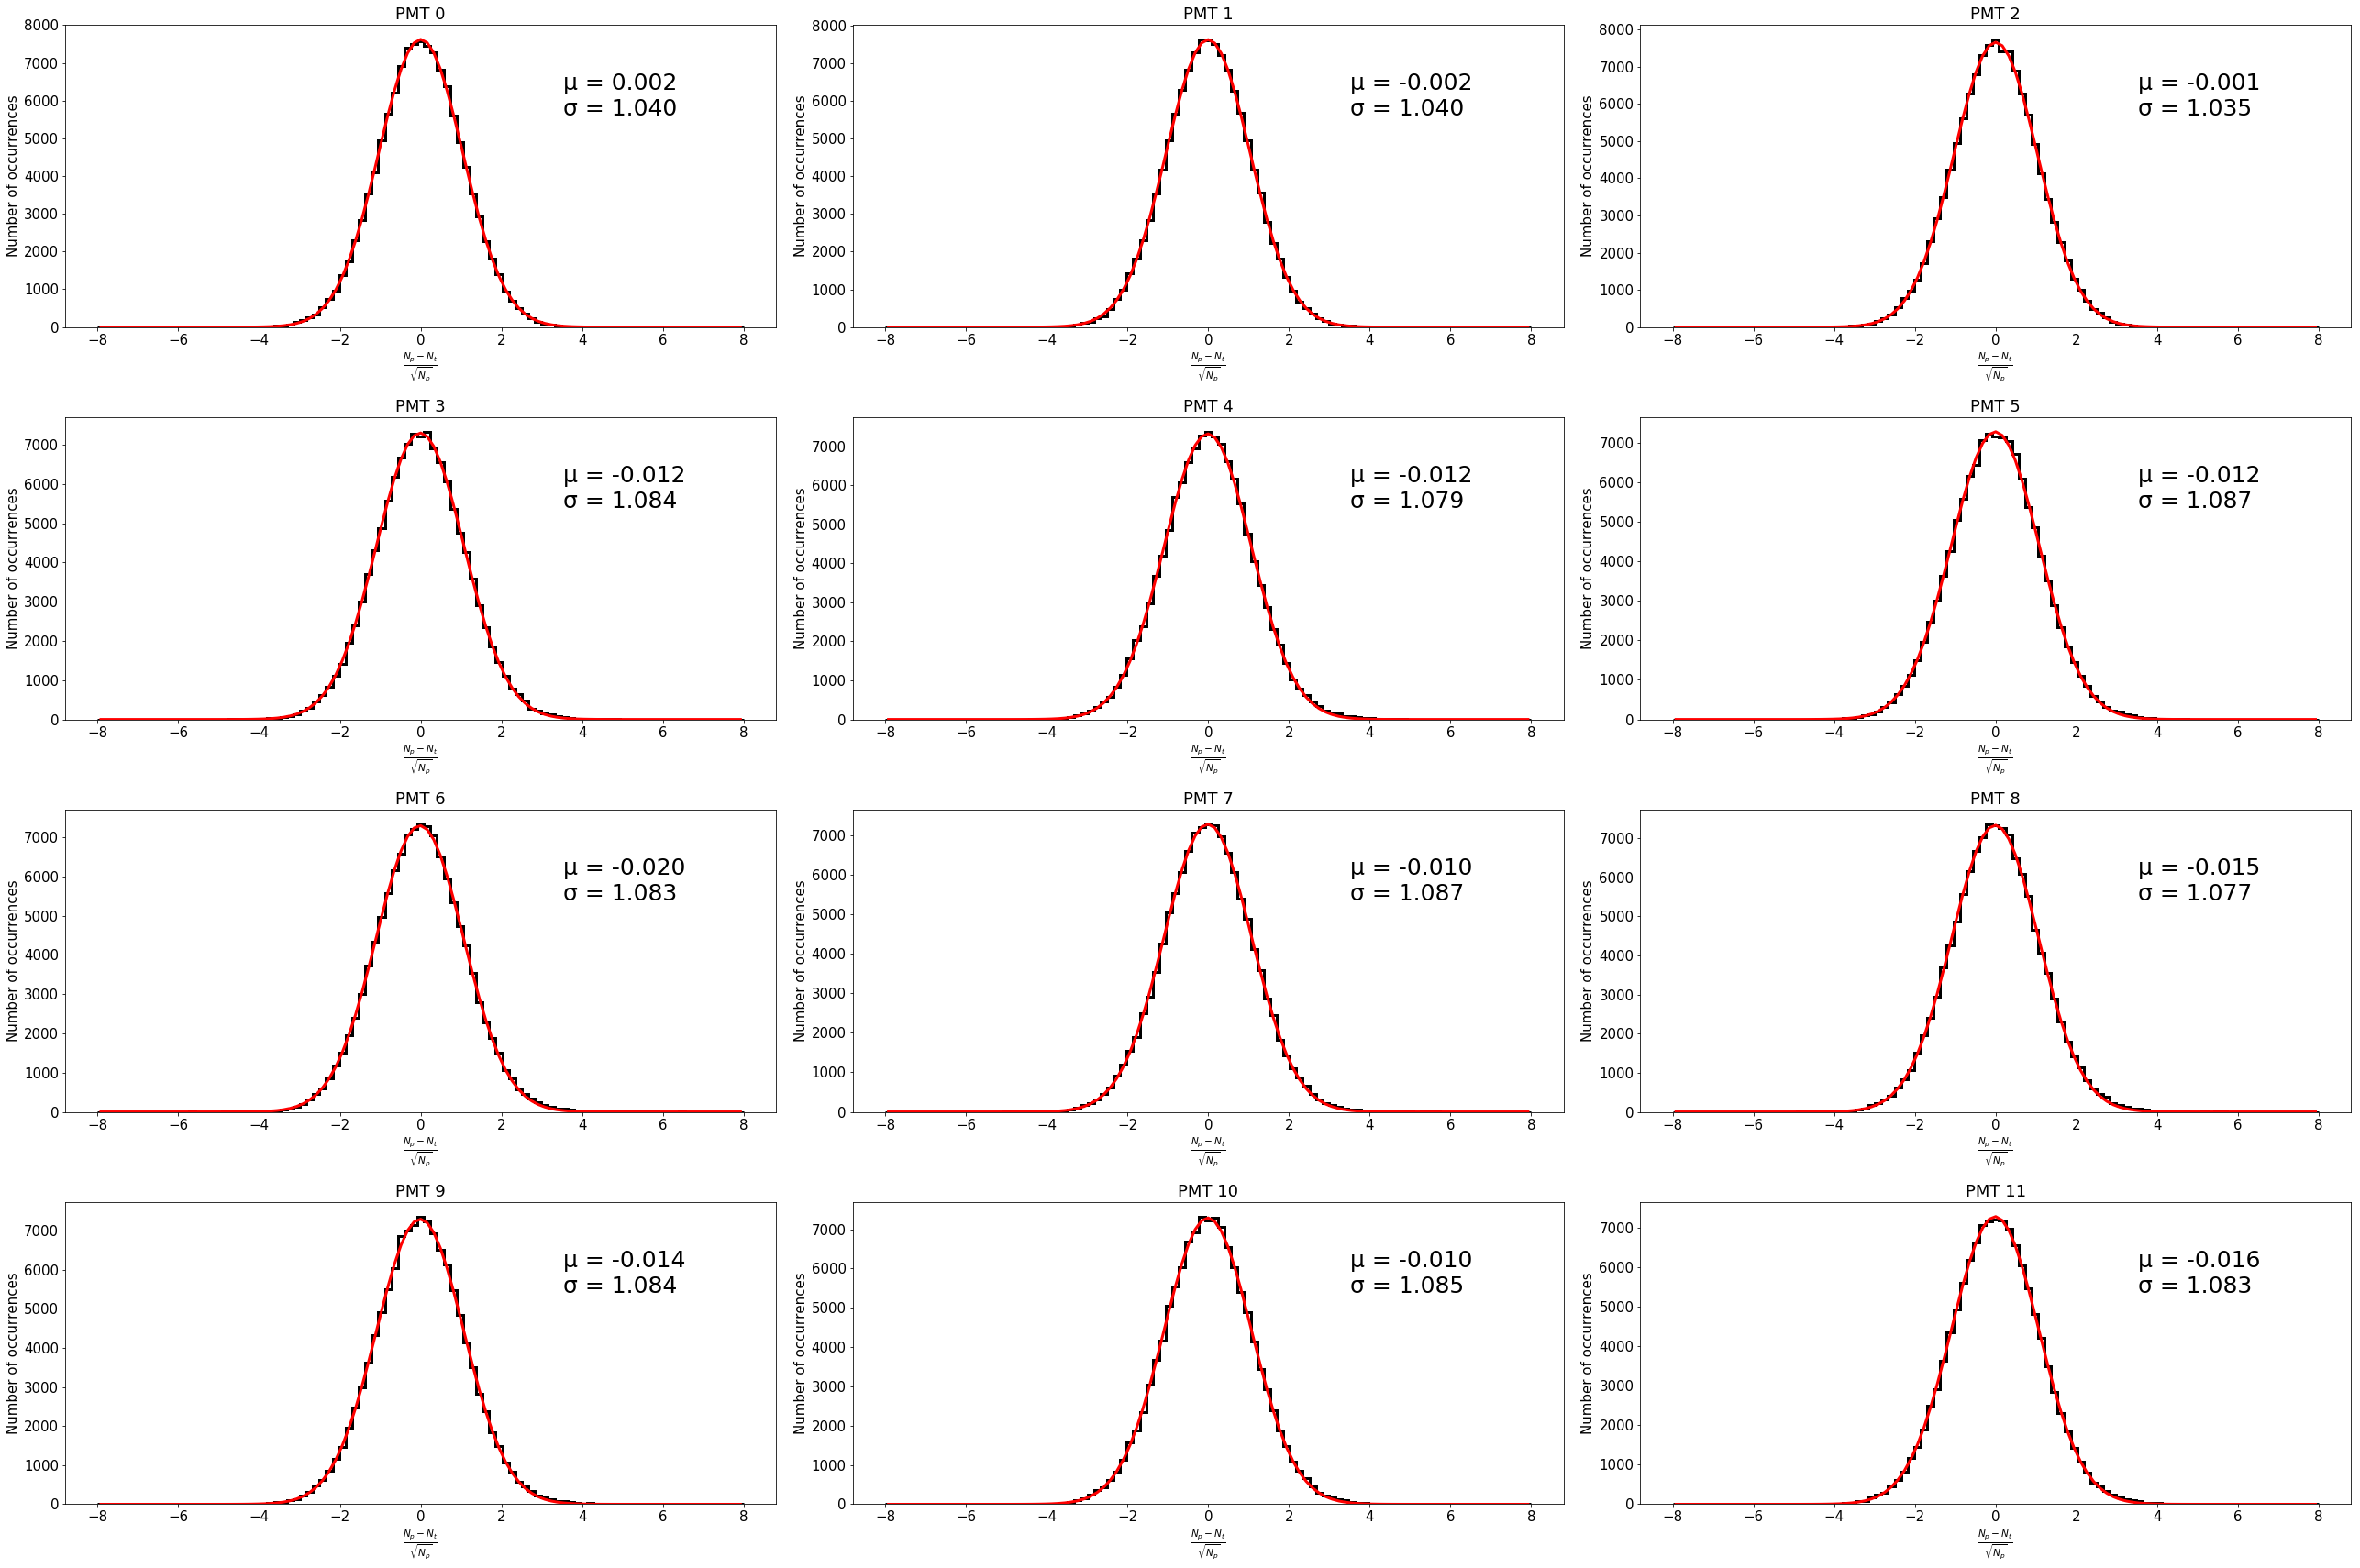

In [98]:
plt.figure(figsize=(36, 24))
pull_binning = np.linspace(-8, 8, 100)

for pmt_no, pmt in df_cathode.groupby("SensorID"):
    pull = pulls[pmt_no]
    y, x = np.histogram(pull, pull_binning)
    x    = x[:-1] + np.diff(x) / 2
    f    = fitf.fit(fitf.gauss, x, y, (1e4, 0, 1))

    plt.subplot(4, 3, pmt_no + 1)
    plt.hist(pull, pull_binning, histtype="step", color="k", lw=3)
    plt.plot(x, f.fn(x), "r-", lw=3)
    plt.text(0.7, 0.7, f"µ = {f.values[1]:.3f}\nσ = {f.values[2]:.3f}", transform=plt.gca().transAxes, fontsize=25)
    plt.xlabel(r"$\frac{N_{p} - N_{t}}{\sqrt{N_{p}}}$")
    plt.ylabel("Number of occurrences")
    plt.title (f"PMT {pmt_no}")
    plt.tight_layout()

In [9]:
df_cathode.set_index?

Signature: df_cathode.set_index(keys, drop=True, append=False, inplace=False, verify_integrity=False)
Docstring:
Set the DataFrame index (row labels) using one or more existing
columns. By default yields a new object.

Parameters
----------
keys : column label or list of column labels / arrays
drop : boolean, default True
    Delete columns to be used as the new index
append : boolean, default False
    Whether to append columns to existing index
inplace : boolean, default False
    Modify the DataFrame in place (do not create a new object)
verify_integrity : boolean, default False
    Check the new index for duplicates. Otherwise defer the check until
    necessary. Setting to False will improve the performance of this
    method

Examples
--------
>>> indexed_df = df.set_index(['A', 'B'])
>>> indexed_df2 = df.set_index(['A', [0, 1, 2, 0, 1, 2]])
>>> indexed_df3 = df.set_index([[0, 1, 2, 0, 1, 2]])

Returns
-------
dataframe : DataFrame
File:      /Applications/anaconda3/envs/IC3.6/li

In [14]:
df_cathode.head()

,Dummy,PointID,SensorID,X,Y,R,Phi,Sum,P0,P1,...,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19
0,1,1060,0,-186.0,-29.0,188.247178,-2.986924,0.000437,0.000020,0.000022,...,0.000022,0.000020,0.000022,0.000022,0.000022,0.000025,0.000022,0.000022,0.000023,0.000020
1,1,1060,1,-186.0,-29.0,188.247178,-2.986924,0.000437,0.000019,0.000022,...,0.000023,0.000022,0.000022,0.000022,0.000023,0.000022,0.000021,0.000022,0.000023,0.000022
2,1,1060,2,-186.0,-29.0,188.247178,-2.986924,0.000429,0.000021,0.000024,...,0.000022,0.000022,0.000020,0.000023,0.000021,0.000021,0.000023,0.000021,0.000019,0.000023
3,1,1060,3,-186.0,-29.0,188.247178,-2.986924,0.000318,0.000014,0.000017,...,0.000016,0.000014,0.000017,0.000014,0.000016,0.000015,0.000016,0.000016,0.000016,0.000014
4,1,1060,4,-186.0,-29.0,188.247178,-2.986924,0.000329,0.000014,0.000014,...,0.000019,0.000017,0.000017,0.000016,0.000018,0.000017,0.000016,0.000016,0.000014,0.000016


In [15]:
el

,PointID,X,Y
0,0,-198.0,0.0
1,1,-197.0,-19.0
2,2,-197.0,-18.0
3,3,-197.0,-17.0
4,4,-197.0,-16.0


In [20]:
np.all(df_cathode.PointID.map(el.X) == df_cathode.X)

True

In [21]:
df_cathode.PointID

0           1060
1           1060
2           1060
3           1060
4           1060
5           1060
6           1060
7           1060
8           1060
9           1060
10          1060
11          1060
12          1061
13          1061
14          1061
15          1061
16          1061
17          1061
18          1061
19          1061
20          1061
21          1061
22          1061
23          1061
24          1062
25          1062
26          1062
27          1062
28          1062
29          1062
           ...  
1477422    39147
1477423    39147
1477424    39147
1477425    39147
1477426    39147
1477427    39147
1477428    39148
1477429    39148
1477430    39148
1477431    39148
1477432    39148
1477433    39148
1477434    39148
1477435    39148
1477436    39148
1477437    39148
1477438    39148
1477439    39148
1477440    39149
1477441    39149
1477442    39149
1477443    39149
1477444    39149
1477445    39149
1477446    39149
1477447    39149
1477448    39149
1477449    391

In [22]:
el.X

0        -198.0
1        -197.0
2        -197.0
3        -197.0
4        -197.0
5        -197.0
6        -197.0
7        -197.0
8        -197.0
9        -197.0
10       -197.0
11       -197.0
12       -197.0
13       -197.0
14       -197.0
15       -197.0
16       -197.0
17       -197.0
18       -197.0
19       -197.0
20       -197.0
21       -197.0
22       -197.0
23       -197.0
24       -197.0
25       -197.0
26       -197.0
27       -197.0
28       -197.0
29       -197.0
          ...  
123091    197.0
123092    197.0
123093    197.0
123094    197.0
123095    197.0
123096    197.0
123097    197.0
123098    197.0
123099    197.0
123100    197.0
123101    197.0
123102    197.0
123103    197.0
123104    197.0
123105    197.0
123106    197.0
123107    197.0
123108    197.0
123109    197.0
123110    197.0
123111    197.0
123112    197.0
123113    197.0
123114    197.0
123115    197.0
123116    197.0
123117    197.0
123118    197.0
123119    197.0
123120    198.0
Name: X, Length: 123121,

In [23]:
df_cathode.PointID.map(el.X)

0         -186.0
1         -186.0
2         -186.0
3         -186.0
4         -186.0
5         -186.0
6         -186.0
7         -186.0
8         -186.0
9         -186.0
10        -186.0
11        -186.0
12        -186.0
13        -186.0
14        -186.0
15        -186.0
16        -186.0
17        -186.0
18        -186.0
19        -186.0
20        -186.0
21        -186.0
22        -186.0
23        -186.0
24        -186.0
25        -186.0
26        -186.0
27        -186.0
28        -186.0
29        -186.0
           ...  
1477422    -57.0
1477423    -57.0
1477424    -57.0
1477425    -57.0
1477426    -57.0
1477427    -57.0
1477428    -57.0
1477429    -57.0
1477430    -57.0
1477431    -57.0
1477432    -57.0
1477433    -57.0
1477434    -57.0
1477435    -57.0
1477436    -57.0
1477437    -57.0
1477438    -57.0
1477439    -57.0
1477440    -57.0
1477441    -57.0
1477442    -57.0
1477443    -57.0
1477444    -57.0
1477445    -57.0
1477446    -57.0
1477447    -57.0
1477448    -57.0
1477449    -57